# Build dataframe to be fed into Map UI

In [1]:
import pandas as pd
import datetime
import numpy as np
from copy import deepcopy
from collections import defaultdict
import ast

# speeding up of pandas.dataframe.apply:
import swifter

import sys
sys.path.append("../")

# angshuman's functions
from HistoricalData.getData import getNearestEpaData, getNearestNoaaData, get_data

# custom helper functions
from importlib import reload
import modelUtils as mu

### Using last week of October as example

In [2]:
# using October
UP_LEFT = (38.008050, -122.536985)    
UP_RIGHT = (38.008050, -122.186437)   
DOWN_RIGHT = (37.701933, -122.186437) 
DOWN_LEFT = (37.701933, -122.536985)  
START_DATE = '2019/10/12' 
END_DATE = '2019/10/18'   
START_HOUR = '0'        
END_HOUR = '24'

## Load static features/grid

In [3]:
static_features = pd.read_csv("static_data.csv")

In [4]:
# delete old index column
static_features.drop(columns=['Unnamed: 0'], inplace = True)

In [5]:
static_features.head()

,min_lat,max_lat,min_lon,max_lon,x,y,center_lat,center_lon,in_water,ndvi,elevation,NN_list,closest_epa,closest_NOAA
0,37.822662,37.826210,-122.536985,-122.532493,0,34,37.824436,-122.534739,False,-2000,17,"[18753, 5642, 21203, 19297, 18907]",San Francisco,KSFO
1,37.826210,37.829757,-122.536985,-122.532493,0,35,37.827984,-122.534739,False,-2000,0,"[18753, 5642, 21203, 19297, 18907]",San Francisco,KSFO
2,37.829757,37.833305,-122.536985,-122.532493,0,36,37.831531,-122.534739,False,-2000,0,"[18753, 5642, 21203, 19297, 18907]",San Francisco,KSFO
3,37.833305,37.836852,-122.536985,-122.532493,0,37,37.835079,-122.534739,False,5159,55,"[18753, 5642, 21203, 19297, 18907]",San Francisco,KSFO
4,37.836852,37.840400,-122.536985,-122.532493,0,38,37.838626,-122.534739,False,7053,132,"[18753, 5642, 18907, 21203, 19297]",San Francisco,KSFO


## Load PA/temp/humidity

In [6]:
%%time
PA_df = get_data(UP_LEFT, UP_RIGHT, DOWN_RIGHT, DOWN_LEFT, 
                 START_DATE, END_DATE, START_HOUR, END_HOUR)

CPU times: user 11.3 s, sys: 1.41 s, total: 12.7 s
Wall time: 14.4 s


In [7]:
reload(mu)
boxes = pd.read_csv("../500m_grid.csv")
sensor_locs = PA_df[['sensor_id', 'lat', 'lon']].drop_duplicates(subset=['sensor_id'])
sensor_locs['xy_'] = sensor_locs.apply(lambda l: mu.get_coords(l,boxes), axis = 1)
sensor_locs.set_index("sensor_id",drop = True, inplace = True)

In [8]:
PA_df.columns

Index(['0_3um', '0_5um', '1_0um', '2_5um', '5_0um', '10_0um', 'pm1_0',
       'pm10_0', 'created', 'pm1_0_atm', 'pm2_5_atm', 'pm10_0_atm', 'uptime',
       'rssi', 'temperature', 'humidity', 'pm2_5_cf_1', 'device_loc_typ',
       'is_owner', 'sensor_id', 'sensor_name', 'parent_id', 'lat', 'lon',
       'thingspeak_primary_id', 'thingspeak_primary_id_read_key',
       'thingspeak_secondary_id', 'thingspeak_secondary_id_read_key', 'a_h',
       'high_reading_flag', 'hidden', 'city', 'county', 'zipcode',
       'created_at', 'year', 'month', 'day', 'hour', 'minute', 'wban_number',
       'call_sign', 'call_sign2', 'interval', 'call_sign3', 'zulu_time',
       'report_modifier', 'wind_data', 'wind_direction', 'wind_speed', 'gusts',
       'gust_speed', 'variable_winds', 'variable_wind_info', 'sys_maint_reqd',
       'agency_name', 'aqi', 'category', 'epa_pm25_unit', 'epa_pm25_value',
       'full_aqs_code', 'intl_aqs_code', 'raw_concentration', 'site_name'],
      dtype='object')

In [9]:
reload(mu)
# keep only readings on the hour
# drop 2.5 readings > 300
# assign time-space id
# drop columns I don't care about

filtered_PA_df = PA_df[(PA_df['2_5um'] < 300) & (PA_df.minute == '00')]\
                    .assign(ts_ = lambda df_: df_['created'].map(mu.parse_date),
                            xy_ = lambda df_: df_['sensor_id'].map(
                                lambda s: sensor_locs.loc[s,'xy_']),
                            time_space_id = lambda df_: df_.apply(mu.time_space, axis = 1)) \
                    .set_index('time_space_id', drop = True)[['2_5um', 'temperature', 'humidity', 'sensor_id', 'ts_']]

filtered_PA_df.head()

,2_5um,temperature,humidity,sensor_id,ts_
time_space_id,,,,,
1570838400_21_5,7.09,86.0,16.0,16931,1570838400
1570842000_21_5,18.27,81.0,22.0,16931,1570842000
1570845600_21_5,6.20,72.0,30.0,16931,1570845600
1570849200_21_5,12.24,66.0,38.0,16931,1570849200
1570852800_21_5,15.73,61.0,42.0,16931,1570852800


In [10]:
humid_temp_lookup = {}

for idx, row in filtered_PA_df.iterrows():
    if row['ts_'] in humid_temp_lookup:
        humid_temp_lookup[row['ts_']][row['sensor_id']] = {'temperature':row['temperature'],
                                                           'humidity':row['humidity']}
    else:
        humid_temp_lookup[row['ts_']] = {}
        humid_temp_lookup[row['ts_']][row['sensor_id']] = {'temperature':row['temperature'],
                                                           'humidity':row['humidity']}

## Get NOAA data based on time and station

In [11]:
%%time
reload(mu)
noaa_lookup = mu.get_noaa_by_date(START_DATE, END_DATE)

CPU times: user 1.23 s, sys: 22.4 ms, total: 1.25 s
Wall time: 10.7 s


## Get EPA data based on time and station

In [12]:
%%time
reload(mu)
epa_lookup = mu.get_epa_by_date(START_DATE, END_DATE)

CPU times: user 848 ms, sys: 39.1 ms, total: 887 ms
Wall time: 9.51 s


## Putting everything together 

In [13]:
# create a df with x y coordinates as indices for fast look up

static_lookup = static_features[~static_features.in_water] \
                    .assign(xy_ = lambda df_: df_.apply(lambda l: f"{l.x}_{l.y}",axis = 1)) \
                    .set_index("xy_", drop = True)

static_lookup['NN_list'] = static_lookup['NN_list'].map(lambda l: ast.literal_eval(l))
static_lookup.head()

,min_lat,max_lat,min_lon,max_lon,x,y,center_lat,center_lon,in_water,ndvi,elevation,NN_list,closest_epa,closest_NOAA
xy_,,,,,,,,,,,,,,
0_34,37.822662,37.826210,-122.536985,-122.532493,0,34,37.824436,-122.534739,False,-2000,17,"[18753, 5642, 21203, 19297, 18907]",San Francisco,KSFO
0_35,37.826210,37.829757,-122.536985,-122.532493,0,35,37.827984,-122.534739,False,-2000,0,"[18753, 5642, 21203, 19297, 18907]",San Francisco,KSFO
0_36,37.829757,37.833305,-122.536985,-122.532493,0,36,37.831531,-122.534739,False,-2000,0,"[18753, 5642, 21203, 19297, 18907]",San Francisco,KSFO
0_37,37.833305,37.836852,-122.536985,-122.532493,0,37,37.835079,-122.534739,False,5159,55,"[18753, 5642, 21203, 19297, 18907]",San Francisco,KSFO
0_38,37.836852,37.840400,-122.536985,-122.532493,0,38,37.838626,-122.534739,False,7053,132,"[18753, 5642, 18907, 21203, 19297]",San Francisco,KSFO


In [14]:
static_lookup_dict = static_lookup.to_dict()

In [15]:
xy_lookup = static_lookup[['center_lat','center_lon']].T.to_dict()


In [16]:
from itertools import product
reload(mu)
# every date string in our pre-defined period
date_strs = mu.hourly_date_range(START_DATE, END_DATE)

# every xy coordinate in static features
xy_s = [(x,y) for x,y in zip(static_features['x'], static_features['y'])]

# dataframe
input_set = pd.DataFrame(product(date_strs,xy_s), columns = ['ts_', 'xy_']) \
                .assign(dt_ = lambda df_: pd.to_datetime(df_['ts_'], unit='s'))
assert input_set.shape[0] == len(date_strs) * len(xy_s)
input_set.head()

,ts_,xy_,dt_
0,1570838400,"(0, 34)",2019-10-12
1,1570838400,"(0, 35)",2019-10-12
2,1570838400,"(0, 36)",2019-10-12
3,1570838400,"(0, 37)",2019-10-12
4,1570838400,"(0, 38)",2019-10-12


In [35]:
# EPA value
def nearest_epa(line):
    
    ## will need to pass in static lookup/epa_lookup
    nearest_epa_station = mu.format_name(static_lookup.loc[f"{line.xy_[0]}_{line.xy_[1]}", 'closest_epa'])
    if f"{line.ts_}_{nearest_epa_station}" in epa_lookup:
        return epa_lookup[f"{line.ts_}_{nearest_epa_station}"]
    else:
        return np.nan

input_set['epa_pm25_value'] = input_set.apply(nearest_epa, axis =1)

In [18]:
%%time
# humidity/temperature from PA
def nearest_humid_temp(line):
    NN_list = static_lookup['NN_list'][f"{line.xy_[0]}_{line.xy_[1]}"]
    
    for NN in NN_list:
        if str(NN) in humid_temp_lookup[line.ts_]:
            humidity = humid_temp_lookup[line.ts_][str(NN)]['humidity']
            temperature = humid_temp_lookup[line.ts_][str(NN)]['temperature']
            break
    else:
        humidity = np.nan
        temperature = np.nan
    
    return humidity, temperature

input_set['humidity'], input_set['temperature'] = zip(*input_set.apply(nearest_humid_temp, axis = 1))

CPU times: user 58.4 s, sys: 44 ms, total: 58.4 s
Wall time: 57.1 s


In [19]:
how_many_nan = lambda x: np.isnan(x).mean()
how_many_nan(input_set['humidity']), how_many_nan(input_set['temperature'])

(0.07470630806516763, 0.07470630806516763)

In [36]:
# avg temp, humid by timestamp for filling in null values
avg_hum_temp = input_set.groupby('ts_').agg({'humidity':'mean', 'temperature':'mean', 'epa_pm25_value':'mean'})

def fill_in_avgs(line, val):
    if np.isnan(line[val]):
        return avg_hum_temp.loc[line.ts_, val]
    else:
        return line[val]

In [21]:
input_set['humidity'] = input_set.apply(lambda l: fill_in_avgs(l, 'humidity'), axis = 1)
input_set['temperature'] = input_set.apply(lambda l: fill_in_avgs(l, 'temperature'), axis = 1)


In [37]:
input_set['epa_pm25_value'] = input_set.apply(lambda l: fill_in_avgs(l, 'epa_pm25_value'), axis = 1)

In [22]:
how_many_nan(input_set['humidity']), how_many_nan(input_set['temperature'])

(0.0, 0.0)

In [23]:
%%time
# wind x, wind y
def get_wind(line):
    nearest_noaa = static_lookup_dict['closest_NOAA'][f"{line.xy_[0]}_{line.xy_[1]}"]
    
    if len(noaa_lookup[f"{line.ts_}_{nearest_noaa.lower()}"]) != 2:
        return np.nan, np.nan
    
    return noaa_lookup[f"{line.ts_}_{nearest_noaa.lower()}"]

input_set['wind_x'], input_set['wind_y'] = zip(*input_set.apply(get_wind, axis = 1))

CPU times: user 34.6 s, sys: 32.1 ms, total: 34.7 s
Wall time: 34.7 s


In [24]:
avg_wind = input_set.fillna(0).groupby('ts_').agg({'wind_x':'mean', 'wind_y':'mean'})

In [25]:
def fill_in_avgs_wind(line, val):
    if np.isnan(line[val]):
        return avg_wind.loc[line.ts_, val]
    else:
        return line[val]
    
input_set['wind_x'] = input_set.apply(lambda l: fill_in_avgs_wind(l, 'wind_x'), axis = 1)
input_set['wind_y'] = input_set.apply(lambda l: fill_in_avgs_wind(l, 'wind_y'), axis = 1)

In [26]:
how_many_nan(input_set['wind_x']), how_many_nan(input_set['wind_y'])

(0.0, 0.0)

In [41]:
%%time
# ndvi, elevation
def get_ndvi(xy_):
    return max(static_lookup['ndvi'][f"{xy_[0]}_{xy_[1]}"], 0)

def get_elevation(xy_):
    return static_lookup['elevation'][f"{xy_[0]}_{xy_[1]}"]


input_set['ndvi'] = input_set.xy_.map(get_ndvi)
#input_set['elevation'] = input_set.xy_.map(get_elevation)

CPU times: user 6.44 s, sys: 0 ns, total: 6.44 s
Wall time: 6.43 s


In [28]:
# neighbors
neighbor_lookup = defaultdict(list)
_ = filtered_PA_df.apply(lambda x: neighbor_lookup[x.name].append(x['2_5um']), axis = 1)

In [46]:

def get_neighbors_space_time(line, train_df):
    """
    Inputs: single observation, a training dataframe, and a time delta
    Outputs: vector of length 24 corresponding to surrounding neighbor observations
    """   
    t = line.ts_
    x = line.xy_[0]
    y = line.xy_[1]
    neighbors = np.zeros((25))
    
    c = 0
    for i in range(-2,3):
        for j in range(-2,3):
            n = neighbor_lookup[f"{t}_{x+i}_{y+j}"] # get rows in train_df for that particular time-block
            
            if n:
                neighbors[c] = np.mean(n)
            c += 1
    
    return neighbors

In [47]:
input_neighbors = input_set.apply(lambda x: get_neighbors_space_time(x, filtered_PA_df), axis = 1)

In [38]:
cols = ['epa_pm25_value', 'humidity', 'temperature', 'wind_x', 'wind_y', 'ndvi']


In [48]:
final_input = np.concatenate((input_set[cols].to_numpy(), 
                              np.stack(input_neighbors.values)),
                             axis = 1)
final_input.shape

(712992, 31)

In [77]:
eight22 = (input_set.xy_ == (8,22))

# Load Model from File

In [40]:
%%time
from joblib import load

rf = load("updated_rf.joblib")

CPU times: user 5.65 s, sys: 11.1 s, total: 16.8 s
Wall time: 1min 43s


In [49]:
%%time
preds = rf.predict(final_input)

CPU times: user 1min 39s, sys: 2.78 s, total: 1min 42s
Wall time: 25.8 s


In [50]:
mapped_preds = pd.DataFrame({'xy_':input_set.xy_, 'preds':preds})

In [51]:
avg_preds = mapped_preds.groupby('xy_').agg({'preds':'mean'}).reset_index()
avg_preds['lat'] = avg_preds.xy_.map(lambda p: static_lookup.loc[f"{p[0]}_{p[1]}",'center_lat'] )
avg_preds['lon'] = avg_preds.xy_.map(lambda p: static_lookup.loc[f"{p[0]}_{p[1]}",'center_lon'] )

In [95]:
avg_preds.head()

,xy_,preds,lat,lon
0,"(0, 34)",7.557789,37.824436,-122.534739
1,"(0, 35)",9.327058,37.827984,-122.534739
2,"(0, 36)",9.669660,37.831531,-122.534739
3,"(0, 37)",10.905424,37.835079,-122.534739
4,"(0, 38)",6.560405,37.838626,-122.534739


In [52]:
%matplotlib inline
from matplotlib import pyplot as plt

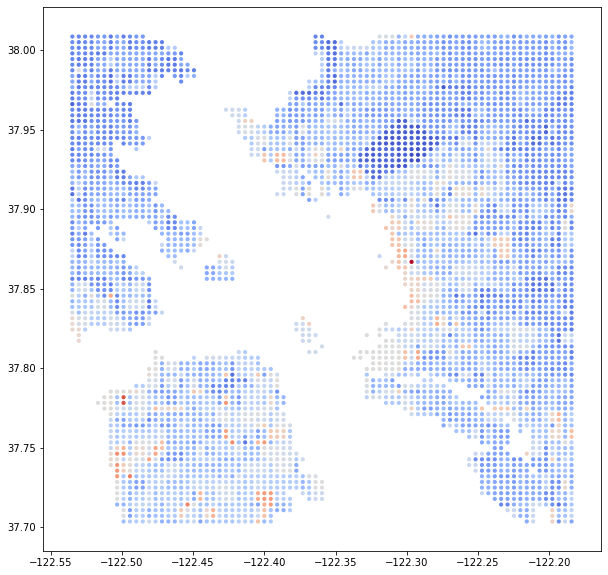

In [55]:
f, a = plt.subplots(figsize = (10,10))
a.scatter(x = avg_preds['lon'],
          y = avg_preds['lat'],
          c = avg_preds['preds'],
          cmap = 'coolwarm',
          s = 10)

In [58]:
# look at avg results from previous model
df2 = pd.read_csv("1018_1024_avg_preds.csv")

In [67]:
min(min(df2['preds']), min(avg_preds['preds']))

1.3747854308390024

Text(0.5, 1.0, 'without elevation as parameter')

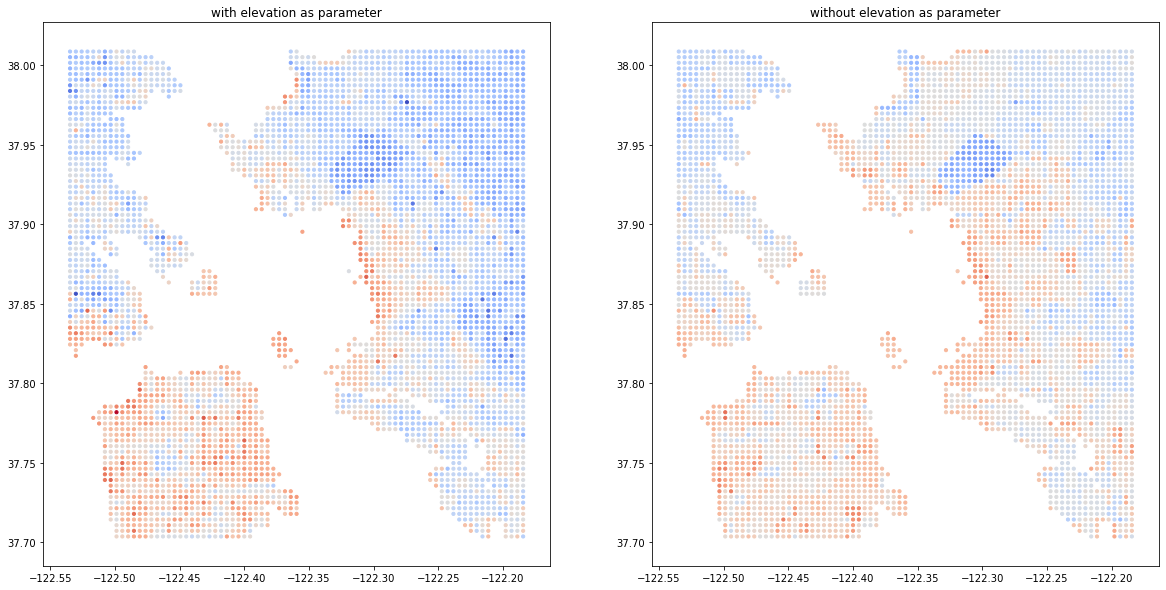

In [70]:
from matplotlib import cm

we_ = np.log(df2['preds'])
wo_ = np.log(avg_preds['preds'])

norm = cm.colors.Normalize(vmin = min(min(we_), min(wo_)),
                           vmax = max(max(we_), max(wo_)))

f, a = plt.subplots(ncols = 2, figsize = (20,10))
a[0].scatter(x = df2['lon'],
          y = df2['lat'],
          c = we_,
          cmap = 'coolwarm',
          norm = norm,
          s = 10)
a[0].set_title("with elevation as parameter")

a[1].scatter(x = avg_preds['lon'],
          y = avg_preds['lat'],
          c = wo_,
          cmap = 'coolwarm',
          norm = norm,  
          s = 10)
a[1].set_title("without elevation as parameter")

In [57]:
avg_preds.sort_values(by=['preds'], ascending = False).head()

,xy_,preds,lat,lon
2258,"(53, 46)",14.248037,37.866998,-122.296686
469,"(8, 21)",12.962685,37.778299,-122.498807
470,"(8, 22)",12.962685,37.781849,-122.498807
524,"(9, 8)",11.959816,37.732134,-122.494315
981,"(18, 3)",11.795655,37.714370,-122.453891


In [71]:
df2.sort_values(by=['preds'], ascending = False).head()

,xy_,preds,lat,lon
470,"(8, 22)",19.715235,37.781849,-122.498807
1175,"(23, 21)",14.568485,37.778299,-122.431433
2130,"(51, 46)",14.059864,37.866998,-122.305669
1424,"(30, 17)",13.788756,37.764097,-122.399992
387,"(7, 10)",13.721696,37.739238,-122.503298


In [73]:
np.var(avg_preds['preds']), np.var(df2['preds'])

(2.484981677316059, 4.070157992481406)

In [74]:
np.mean(avg_preds['preds']), np.mean(df2['preds'])

(5.55723145650265, 4.972890660842415)

## resaving file with all the features

In [100]:
avg_preds.head()

,xy_,preds,lat,lon
0,"(0, 34)",7.557789,37.824436,-122.534739
1,"(0, 35)",9.327058,37.827984,-122.534739
2,"(0, 36)",9.669660,37.831531,-122.534739
3,"(0, 37)",10.905424,37.835079,-122.534739
4,"(0, 38)",6.560405,37.838626,-122.534739


In [102]:
neighbor_matrix = np.stack(input_neighbors.values)

for n in range(24):
    input_set[f'neighbor_{n}'] = neighbor_matrix[:,n]

In [104]:
# should have been how = right
input_set.merge(avg_preds[['xy_', 'preds']], on = ['xy_']).to_csv("avg_preds_w_features.csv", index = False)

In [105]:
import subprocess
subprocess.run(f"/home/ubuntu/miniconda3/bin/aws s3 cp avg_preds_w_features.csv s3://capstone-air-pollution/model_stuff/avg_preds_w_features.csv", shell = True)

CompletedProcess(args='/home/ubuntu/miniconda3/bin/aws s3 cp avg_preds_w_features.csv s3://capstone-air-pollution/model_stuff/avg_preds_w_features.csv', returncode=0)

In [106]:
pd.read_csv("avg_preds_w_features.csv").head()

,ts_,xy_,dt_,epa_pm_25_value,humidity,temperature,wind_x,wind_y,ndvi,elevation,...,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20,neighbor_21,neighbor_22,neighbor_23,preds
0,1571356800,"(0, 34)",2019-10-18 00:00:00,7.1,60.0,65.0,-1.215537,-6.893654,-2000,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.557789
1,1571360400,"(0, 34)",2019-10-18 01:00:00,6.0,64.0,64.0,1.389185,-7.878462,-2000,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.557789
2,1571364000,"(0, 34)",2019-10-18 02:00:00,4.5,66.0,63.0,1.389185,-7.878462,-2000,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.557789
3,1571367600,"(0, 34)",2019-10-18 03:00:00,5.7,58.0,63.0,1.041889,-5.908847,-2000,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.557789
4,1571371200,"(0, 34)",2019-10-18 04:00:00,7.3,56.0,64.0,0.868241,-4.924039,-2000,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.557789


## other things I should output

- how many nearby sensors
- distance to nearest sensor
- uncertainty?

In [1]:
import pandas as pd
preds = pd.read_csv("avg_preds_w_features.csv")

In [2]:
def n_neighbors(line):
    c = 0
    for n in range(24):
        if line[f"neighbor_{n}"] > 0:
            c +=1
    return c

preds['n_neighbors'] = preds.apply(n_neighbors, axis = 1)

KeyboardInterrupt: 

In [4]:
preds['n_neighbors'].describe()

count    712992.000000
mean          0.825231
std           1.382625
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          10.000000
Name: n_neighbors, dtype: float64

In [ ]:
avg_preds['lonely_factor'] = 1 / (avg_preds['n_neighbors'] + 1)

In [13]:
preds.groupby('n_neighbors').count()

,ts_,xy_,dt_,epa_pm_25_value,humidity,temperature,wind_x,wind_y,ndvi,elevation,...,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20,neighbor_21,neighbor_22,neighbor_23,preds
n_neighbors,,,,,,,,,,,,,,,,,,,,,
0,430574,430574,430574,430574,430574,430574,430574,430574,430574,430574,...,430574,430574,430574,430574,430574,430574,430574,430574,430574,430574
1,137612,137612,137612,137612,137612,137612,137612,137612,137612,137612,...,137612,137612,137612,137612,137612,137612,137612,137612,137612,137612
2,66487,66487,66487,66487,66487,66487,66487,66487,66487,66487,...,66487,66487,66487,66487,66487,66487,66487,66487,66487,66487
3,38374,38374,38374,38374,38374,38374,38374,38374,38374,38374,...,38374,38374,38374,38374,38374,38374,38374,38374,38374,38374
4,19675,19675,19675,19675,19675,19675,19675,19675,19675,19675,...,19675,19675,19675,19675,19675,19675,19675,19675,19675,19675
5,7680,7680,7680,7680,7680,7680,7680,7680,7680,7680,...,7680,7680,7680,7680,7680,7680,7680,7680,7680,7680
6,5725,5725,5725,5725,5725,5725,5725,5725,5725,5725,...,5725,5725,5725,5725,5725,5725,5725,5725,5725,5725
7,4811,4811,4811,4811,4811,4811,4811,4811,4811,4811,...,4811,4811,4811,4811,4811,4811,4811,4811,4811,4811
8,1213,1213,1213,1213,1213,1213,1213,1213,1213,1213,...,1213,1213,1213,1213,1213,1213,1213,1213,1213,1213


In [31]:
(preds.ndvi == -2000).mean()

0.0322808671065033

In [11]:
import ast
preds['xy_'] = preds['xy_'].map(ast.literal_eval)

In [12]:
preds_a = preds[preds.ndvi != -2000]

In [13]:
#preds['xy_'] = preds.xy_.map(ast.literal_eval)
avg_preds = preds_a.groupby('xy_').agg({'n_neighbors':'mean', 'preds':'mean'}).reset_index()
avg_preds['lat'] = avg_preds.xy_.map(lambda p: static_lookup.loc[f"{p[0]}_{p[1]}",'center_lat'] )
avg_preds['lon'] = avg_preds.xy_.map(lambda p: static_lookup.loc[f"{p[0]}_{p[1]}",'center_lon'] )

In [14]:
avg_preds['lonely_factor'] = 11 / (avg_preds['n_neighbors'] + 1)

In [16]:
avg_preds.head()

,xy_,n_neighbors,preds,lat,lon,lonely_factor
0,"(0, 37)",0.994048,10.905424,37.835079,-122.534739,5.516418
1,"(0, 38)",0.994048,6.560405,37.838626,-122.534739,5.516418
2,"(0, 39)",0.000000,2.711774,37.842173,-122.534739,11.000000
3,"(0, 40)",0.000000,4.451422,37.845720,-122.534739,11.000000
4,"(0, 41)",0.000000,4.231121,37.849267,-122.534739,11.000000


In [17]:
avg_preds.to_csv("sample_output.csv", index = False)

In [3]:
df = pd.read_csv("sample_output.csv")
df.head()

,xy_,n_neighbors,preds,lat,lon,lonely_factor
0,"(0, 37)",0.994048,10.905424,37.835079,-122.534739,5.516418
1,"(0, 38)",0.994048,6.560405,37.838626,-122.534739,5.516418
2,"(0, 39)",0.000000,2.711774,37.842173,-122.534739,11.000000
3,"(0, 40)",0.000000,4.451422,37.845720,-122.534739,11.000000
4,"(0, 41)",0.000000,4.231121,37.849267,-122.534739,11.000000


In [20]:
lonely_preds = avg_preds[avg_preds.n_neighbors < 0.5]

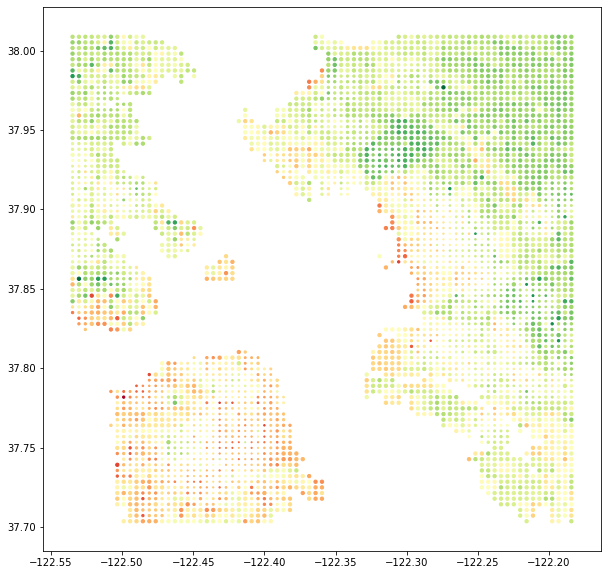

In [39]:
f, a = plt.subplots(figsize = (10,10))

a.scatter(x = avg_preds['lon'],
          y = avg_preds['lat'],
          c = -np.log(avg_preds['preds']),
          cmap = 'RdYlGn',
          s = avg_preds['lonely_factor'])



In [8]:
avg_preds.head()

,xy_,n_neighbors,preds
0,"(0, 34)",0.994048,7.557789
1,"(0, 35)",0.994048,9.327058
2,"(0, 36)",0.000000,9.669660
3,"(0, 37)",0.994048,10.905424
4,"(0, 38)",0.994048,6.560405
